# Resources

- [Blog post](https://medium.com/grabngoinfo/recommendation-system-user-based-collaborative-filtering-a2e76e3e15c4) for this notebook
- Video tutorial on [YouTube](https://www.youtube.com/watch?v=cxcFi3RDrEw&list=PLVppujud2yJqshyM80nNDZgye-AFufyqF&index=1)
- More video tutorials on [recommendation system](https://www.youtube.com/playlist?list=PLVppujud2yJqshyM80nNDZgye-AFufyqF)
- More blog posts on [recommendation system](https://medium.com/@AmyGrabNGoInfo/list/recommendation-system-7ed442471466)

For more information about data science and machine learning, please check out my [YouTube channel](https://www.youtube.com/channel/UCmbA7XB6Wb7bLwJw9ARPcYg), [Medium Page](https://medium.com/@AmyGrabNGoInfo) and [GrabNGoInfo.com](https://grabngoinfo.com/tutorials/).

# Intro

User-based collaborative filtering is also called user-user collaborative filtering. It is a type of recommendation system algorithm that uses user similarity to make product recommendations.

In this tutorial, we will talk about
* What is user-based (user-user) collaborative filtering?
* How to create a user-product matrix?
* How to process data for user-based collaborative filtering?
* How to identify similar users?
* How to narrow down the items pool?
* How to rank items for the recommendation?
* How to predict the rating score?


# Step 0: User-Based Collaborative Filtering Recommendation Algorithm

Firstly, let's understand how User-based collaborative filtering works.

User-based collaborative filtering makes recommendations based on user-product interactions in the past. The assumption behind the algorithm is that similar users like similar products.

User-based collaborative filtering algorithm usually has the following steps:

1. Find similar users based on interactions with common items.
2. Identify the items rated high by similar users but have not been exposed to the active user of interest.
3. Calculate the weighted average score for each item.
4. Rank items based on the score and pick top n items to recommend.

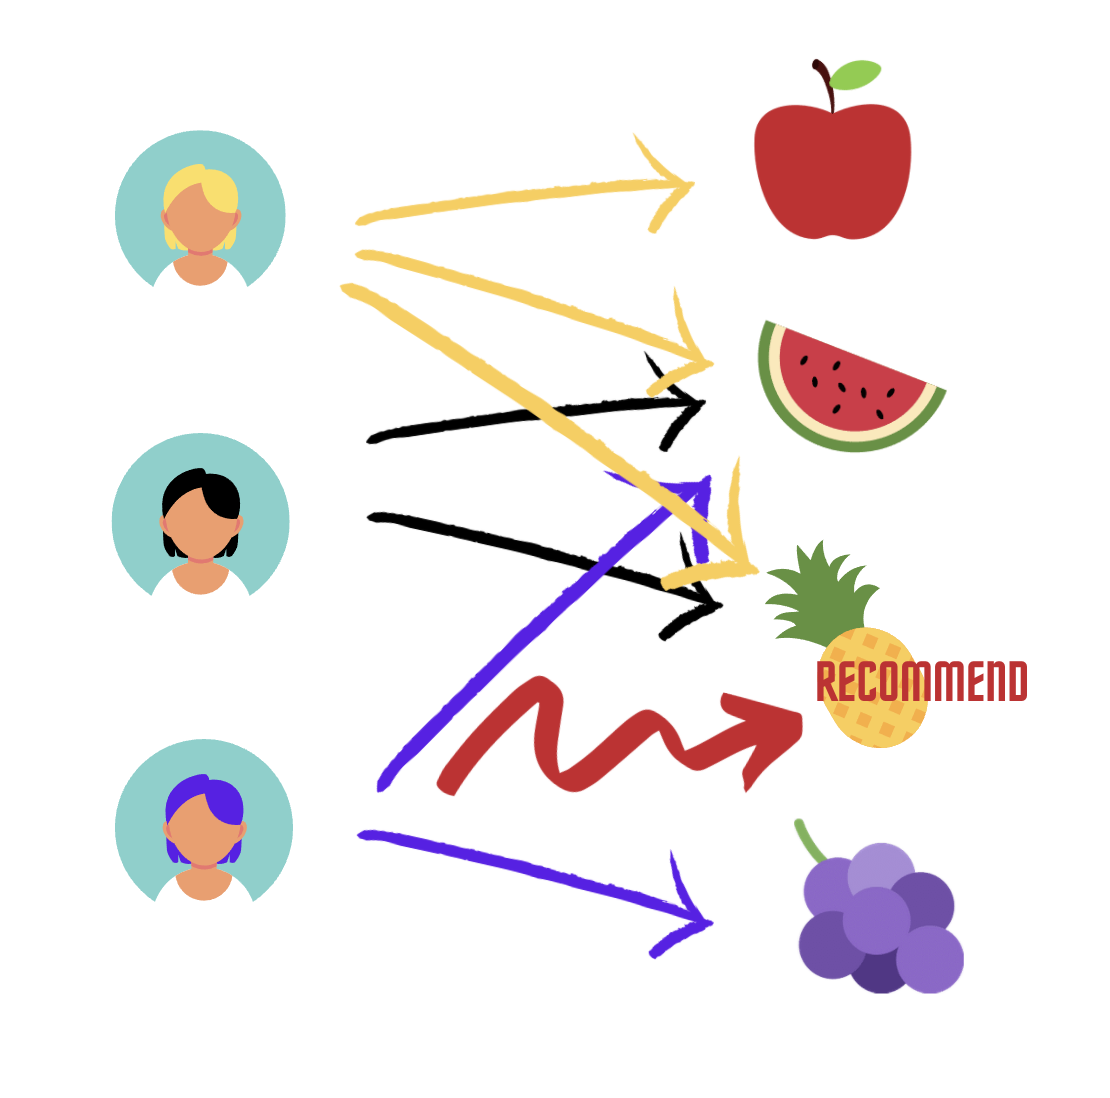

This graph illustrates how item-based collaborative filtering works using a simplified example.
* Ms. Blond likes apples, watermelons, and pineapples. Ms. Black likes watermelon and pineapple. Ms. Purple likes watermelons and grapes. 
* Because Ms. Black and Ms. Purple like both watermelons and pineapples, we consider watermelons and pineapples to be similar items. 
* Since Ms. Purple likes watermelons and has not been exposed to pineapple yet, the recommendation system recommends pineapple to Ms. purple. 

# Step 1: Import Python Libraries

In the first step, we will import Python libraries `pandas`, `numpy`, and `scipy.stats`. These three libraries are for data processing and calculations.

We also imported `seaborn` for visualization and `cosine_similarity` for calculating similarity score.

In [ ]:
# Data processing
import pandas as pd
import numpy as np
import scipy.stats

# Visualization
import seaborn as sns

# Similarity
from sklearn.metrics.pairwise import cosine_similarity

# Step 2: Download And Read In Data

This tutorial uses the movielens dataset. This dataset contains actual user ratings of movies.

In step 2, we will follow the steps below to get the datasets:
1. Go to https://grouplens.org/datasets/movielens/ 
2. Download the 100k dataset with the file name "ml-latest-small.zip"
3. Unzip "ml-latest-small.zip"
4. Copy the "ml-latest-small" folder to your project folder

Those who are using Google Colab for this analysis need to mount Google Drive to read the dataset. You can ignore the code below if you are not using Google Colab.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change directory
import os
os.chdir("drive/My Drive/contents/recommendation_system")

# Print out the current directory
!pwd

Mounted at /content/drive
/content/drive/My Drive/contents/recommendation_system


There are multiple datasets in the 100k movielens folder. For this tutorial, we will use two ratings and movies.

Now let's read in the rating data.

In [ ]:
# Read in data
ratings=pd.read_csv('ml-latest-small/ratings.csv')

# Take a look at the data
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


There are four columns in the ratings dataset, userID, movieID, rating, and timestamp.

The dataset has over 100k records, and there is no missing data.

In [ ]:
# Get the dataset information
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


The 100k ratings are from 610 users on 9724 movies. The rating has ten unique values from 0.5 to 5.

In [ ]:
# Number of users
print('The ratings dataset has', ratings['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', ratings['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', ratings['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(ratings['rating'].unique()))

The ratings dataset has 610 unique users
The ratings dataset has 9724 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


Next, let's read in the movies data to get the movie names. 

The movies dataset has movieID, title, and genres.

In [ ]:
# Read in data
movies = pd.read_csv('ml-latest-small/movies.csv')

# Take a look at the data
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Using 'movieID' as the matching key, we appended movie information to the rating dataset and named it 'df'. So now we have the movie tile and movie rating in the same dataset!


In [ ]:
# Merge ratings and movies datasets
df = pd.merge(ratings, movies, on='movieId', how='inner')

# Take a look at the data
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


# Step 3: Exploratory Data Analysis (EDA)

In step 3, we need to filter the movies and keep only those with over 100 ratings for the analysis. This is to make the calculation manageable by the Google Colab memory. 

To do that, we first group the movies by title, count the number of ratings, and keep only the movies with greater than 100 ratings.

The average ratings for the movies are calculated as well.

From the `.info()` output, we can see that there are 134 movies left.

In [ ]:
# Aggregate by movie
agg_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()

# Keep the movies with over 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]
agg_ratings_GT100.info()                              

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 74 to 9615
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              134 non-null    object 
 1   mean_rating        134 non-null    float64
 2   number_of_ratings  134 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.2+ KB


Let's check what the most popular movies and their ratings are.

In [ ]:
# Check popular movies
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,title,mean_rating,number_of_ratings
3158,Forrest Gump (1994),4.164134,329
7593,"Shawshank Redemption, The (1994)",4.429022,317
6865,Pulp Fiction (1994),4.197068,307
7680,"Silence of the Lambs, The (1991)",4.161290,279
5512,"Matrix, The (1999)",4.192446,278


Next, let's use a `jointplot` to check the correlation between the average rating and the number of ratings.

We can see an upward trend from the scatter plot, showing that popular movies get higher ratings. 

The average rating distribution shows that most movies in the dataset have an average rating of around 4.

The number of rating distribution shows that most movies have less than 150 ratings.

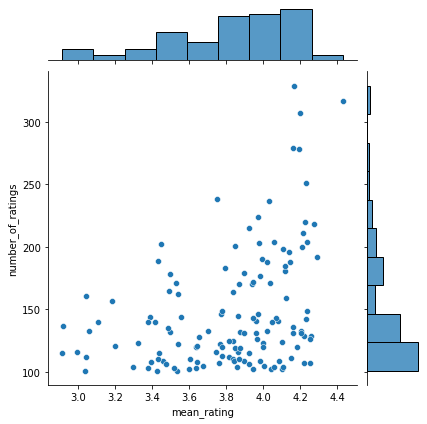

In [ ]:
# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

To keep only the 134 movies with more than 100 ratings, we need to join the movie with the user-rating level dataframe.

`how='inner'` and `on='title'` ensure that only the movies with more than 100 ratings are included.

In [ ]:
# Merge data
df_GT100 = pd.merge(df, agg_ratings_GT100[['title']], on='title', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19788 entries, 0 to 19787
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     19788 non-null  int64  
 1   movieId    19788 non-null  int64  
 2   rating     19788 non-null  float64
 3   timestamp  19788 non-null  int64  
 4   title      19788 non-null  object 
 5   genres     19788 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 1.1+ MB


After filtering the movies with over 100 ratings, we have 597 users that rated 134 movies.

In [ ]:
# Number of users
print('The ratings dataset has', df_GT100['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', df_GT100['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', df_GT100['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(df_GT100['rating'].unique()))

The ratings dataset has 597 unique users
The ratings dataset has 134 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


# Step 4: Create User-Movie Matrix

In step 4, we will transform the dataset into a matrix format. The rows of the matrix are users, and the columns of the matrix are movies. The value of the matrix is the user rating of the movie if there is a rating. Otherwise, it shows 'NaN'.

In [ ]:
# Create user-item matrix
matrix = df_GT100.pivot_table(index='userId', columns='title', values='rating')
matrix.head()

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),Apollo 13 (1995),Austin Powers: The Spy Who Shagged Me (1999),Babe (1995),Back to the Future (1985),Batman (1989),Batman Begins (2005),Batman Forever (1995),"Beautiful Mind, A (2001)",Beauty and the Beast (1991),"Big Lebowski, The (1998)",Blade Runner (1982),"Bourne Identity, The (2002)",Braveheart (1995),"Breakfast Club, The (1985)",Catch Me If You Can (2002),Clear and Present Danger (1994),Clerks (1994),Cliffhanger (1993),"Clockwork Orange, A (1971)",Clueless (1995),Crimson Tide (1995),"Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)",Dances with Wolves (1990),"Dark Knight, The (2008)","Departed, The (2006)",Die Hard (1988),Die Hard: With a Vengeance (1995),Donnie Darko (2001),Dumb & Dumber (Dumb and Dumber) (1994),E.T. the Extra-Terrestrial (1982),...,Pretty Woman (1990),"Princess Bride, The (1987)",Pulp Fiction (1994),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Reservoir Dogs (1992),"Rock, The (1996)",Saving Private Ryan (1998),Schindler's List (1993),Seven (a.k.a. Se7en) (1995),"Shawshank Redemption, The (1994)","Shining, The (1980)",Shrek (2001),"Silence of the Lambs, The (1991)","Sixth Sense, The (1999)",Sleepless in Seattle (1993),Speed (1994),Spider-Man (2002),Star Trek: Generations (1994),Star Wars: Episode I - The Phantom Menace (1999),Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode VI - Return of the Jedi (1983),Stargate (1994),Taxi Driver (1976),Terminator 2: Judgment Day (1991),"Terminator, The (1984)",There's Something About Mary (1998),Titanic (1997),Toy Story (1995),Trainspotting (1996),True Lies (1994),"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,4.0,NaN,NaN,5.0,5.0,NaN,4.0,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,NaN,NaN,4.0,3.0,NaN,5.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,...,NaN,5.0,3.0,5.0,5.0,4.0,4.0,5.0,5.0,NaN,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,5.0,5.0,3.0,NaN,NaN,5.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,NaN,5.0,NaN,NaN,5.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,1.0,3.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,5.0,4.0,1.0,NaN,NaN,NaN,1.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN
5,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,NaN,3.0,NaN,3.0,NaN,5.0,NaN,NaN,NaN,4.0,NaN,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,4.0,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN


# Step 5: Data Normalization

Since some people tend to give a higher rating than others, we normalize the rating by extracting the average rating of each user.

After normalization, the movies with a rating less than the user's average rating get a negative value, and the movies with a rating more than the user's average rating get a positive value.

In [ ]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),Apollo 13 (1995),Austin Powers: The Spy Who Shagged Me (1999),Babe (1995),Back to the Future (1985),Batman (1989),Batman Begins (2005),Batman Forever (1995),"Beautiful Mind, A (2001)",Beauty and the Beast (1991),"Big Lebowski, The (1998)",Blade Runner (1982),"Bourne Identity, The (2002)",Braveheart (1995),"Breakfast Club, The (1985)",Catch Me If You Can (2002),Clear and Present Danger (1994),Clerks (1994),Cliffhanger (1993),"Clockwork Orange, A (1971)",Clueless (1995),Crimson Tide (1995),"Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)",Dances with Wolves (1990),"Dark Knight, The (2008)","Departed, The (2006)",Die Hard (1988),Die Hard: With a Vengeance (1995),Donnie Darko (2001),Dumb & Dumber (Dumb and Dumber) (1994),E.T. the Extra-Terrestrial (1982),...,Pretty Woman (1990),"Princess Bride, The (1987)",Pulp Fiction (1994),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Reservoir Dogs (1992),"Rock, The (1996)",Saving Private Ryan (1998),Schindler's List (1993),Seven (a.k.a. Se7en) (1995),"Shawshank Redemption, The (1994)","Shining, The (1980)",Shrek (2001),"Silence of the Lambs, The (1991)","Sixth Sense, The (1999)",Sleepless in Seattle (1993),Speed (1994),Spider-Man (2002),Star Trek: Generations (1994),Star Wars: Episode I - The Phantom Menace (1999),Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode VI - Return of the Jedi (1983),Stargate (1994),Taxi Driver (1976),Terminator 2: Judgment Day (1991),"Terminator, The (1984)",There's Something About Mary (1998),Titanic (1997),Toy Story (1995),Trainspotting (1996),True Lies (1994),"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,-0.392857,NaN,NaN,0.607143,0.607143,NaN,-0.392857,NaN,NaN,NaN,0.607143,-0.392857,NaN,NaN,NaN,NaN,0.607143,NaN,NaN,-0.392857,NaN,NaN,-0.392857,-1.392857,NaN,0.607143,NaN,NaN,NaN,-0.392857,NaN,NaN,NaN,NaN,NaN,0.607143,0.607143,...,NaN,0.607143,-1.392857,0.607143,0.607143,-0.392857,-0.392857,0.607143,0.607143,NaN,-1.392857,NaN,-0.392857,NaN,NaN,NaN,NaN,NaN,-0.392857,0.607143,0.607143,0.607143,-1.392857,NaN,NaN,0.607143,NaN,NaN,-0.392857,NaN,NaN,NaN,NaN,-1.392857,NaN,0.607143,NaN,NaN,0.607143,0.607143
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.617647,NaN,NaN,NaN,1.617647,NaN,NaN,NaN,NaN,0.617647,NaN,NaN,NaN,NaN,NaN,NaN,-0.382353,0.617647,NaN,NaN,NaN,0.617647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.617647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.617647,-2.382353,-0.382353,NaN,NaN,NaN,NaN,-1.382353,NaN,NaN,NaN,1.617647,0.617647,-2.382353,NaN,NaN,NaN,-2.382353,1.617647,1.617647,NaN,NaN,NaN,NaN,NaN,-0.382353,NaN,NaN,NaN,NaN,NaN,-1.382353,NaN,NaN,NaN,NaN,NaN,0.617647,NaN
5,NaN,-0.461538,0.538462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.461538,NaN,0.538462,NaN,-0.461538,NaN,-0.461538,NaN,1.538462,NaN,NaN,NaN,0.538462,NaN,NaN,-0.461538,NaN,NaN,NaN,-0.4615

# Step 6: Identify Similar Users

There are different ways to measure similarities. Pearson correlation and cosine similarity are two widely used methods.

In this tutorial, we will calculate the user similarity matrix using Pearson correlation.

In [ ]:
# User similarity matrix using Pearson correlation
user_similarity = matrix_norm.T.corr()
user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,569,570,571,572,573,574,575,577,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,NaN,NaN,0.391797,0.180151,-0.439941,-0.029894,0.464277,1.0,-0.037987,0.385758,NaN,NaN,0.175000,0.305392,0.293103,0.088608,0.386777,0.559040,NaN,0.029715,-0.944911,-0.286468,0.222515,-0.166667,0.141421,0.265557,0.040668,0.182059,-0.142857,-0.144579,0.587389,0.228782,0.424871,0.298807,NaN,-0.290037,0.477714,-0.264135,-0.636995,...,-0.750000,0.255934,-0.441261,0.524365,-0.027783,0.643796,-1.0,0.298404,0.094356,0.141170,0.000000,0.250000,-0.288675,-0.076086,-0.188982,0.063525,9.468014e-17,-0.021822,-0.280056,0.222413,-0.030773,-0.105513,0.518245,0.133526,0.866025,0.214037,0.512725,1.00000,0.363218,0.361378,0.091574,0.254514,0.101482,-0.500000,0.780020,0.303854,-0.012077,0.242309,-0.175412,0.071553
2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,-0.752651,0.000000,-0.648886,-0.683130,NaN,NaN,0.612372,-0.772683,NaN,-0.912871,NaN,NaN,NaN,-0.156174,0.500000,NaN,NaN,NaN,1.000000,1.000000,NaN,-1.0,NaN,NaN,NaN,NaN,...,NaN,-0.688247,NaN,NaN,0.203005,NaN,NaN,NaN,NaN,-0.490990,-0.981981,0.000000,NaN,NaN,-0.500000,-0.471405,NaN,NaN,NaN,-0.166667,NaN,NaN,-0.576557,NaN,NaN,0.612372,NaN,NaN,0.000000,0.188982,-0.583333,NaN,-1.000000,NaN,NaN,0.583333,NaN,-0.229416,NaN,0.765641
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.391797,NaN,NaN,1.000000,-0.394823,0.421927,0.704669,0.055442,NaN,0.360399,0.872872,NaN,NaN,0.215166,0.408228,0.046849,-0.194802,-0.071429,0.129813,0.405999,-0.076171,0.944911,-0.519675,0.150739,NaN,NaN,-0.142857,-0.260771,0.478091,NaN,-0.160128,0.329293,-0.107633,-0.043033,NaN,NaN,-0.457496,0.337350,0.274709,-0.764471,...,-0.944911,0.018265,NaN,-0.045954,-0.270623,0.707107,NaN,0.083333,-0.663403,-0.378496,0.803175,-0.613941,-0.807573,-0.127294,-0.578352,-0.147609,0.000000e+00,0.404226,0.000000,0.245289,0.127841,0.465778,0.218745,-0.077152,NaN,-0.332832,0.421433,0.27735,-0.031303,0.301010,-0.239325,0.562500,0.162301,-0.158114,0.905134,0.021898,-0.020659,-0.286872,NaN,-0.050868
5,0.180151,NaN,NaN,-0.394823,1.000000,-0.006888,0.328889,0.030168,NaN,-0.777714,0.486854,1.0,NaN,0.252039,-0.012067,-0.684653,0.310835,0.159568,0.312031,0.000000,-0.339422,NaN,0.000000,0.193649,NaN,0.577350,0.000000,0.180647,-0.681385,0.500000,1.000000,0.287432,0.393029,0.000000,0.293972,NaN,0.297309,0.212246,0.417365,0.194054,...,0.322031,-0.019048,NaN,0.629941,0.270031,-0.042601,NaN,0.648105,0.000000,0.059517,NaN,NaN,-0.622543,0.193012,NaN,-0.423659,7.812000e-01,0.399643,0.777029,0.355059,NaN,0.106676,0.327896,0.198687,NaN,0.406382,0.429064,NaN,0.434656,0.282376,0.000000,0.231642,0.131108,0.068621,-0.245026,0.377341,0.228218,0.263139,0.384111,0.040582


Those who are interested in using cosine similarity can refer to this code. Since `cosine_similarity` does not take missing values, we need to impute the missing values with 0s before the calculation.

In [ ]:
# User similarity matrix using cosine similarity
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
user_similarity_cosine

array([[ 1.        ,  0.        ,  0.        , ...,  0.14893867,
        -0.06003146,  0.04528224],
       [ 0.        ,  1.        ,  0.        , ..., -0.04485403,
        -0.25197632,  0.18886414],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.14893867, -0.04485403,  0.        , ...,  1.        ,
         0.14734568,  0.07931015],
       [-0.06003146, -0.25197632,  0.        , ...,  0.14734568,
         1.        , -0.14276787],
       [ 0.04528224,  0.18886414,  0.        , ...,  0.07931015,
        -0.14276787,  1.        ]])

Now let's use user ID 1 as an example to illustrate how to find similar users. 

We first need to exclude user ID 1 from the similar user list and decide the number of similar users.



In [ ]:
# Pick a user ID
picked_userid = 1

# Remove picked user ID from the candidate list
user_similarity.drop(index=picked_userid, inplace=True)

# Take a look at the data
user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,569,570,571,572,573,574,575,577,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,-0.752651,0.000000,-0.648886,-0.683130,NaN,NaN,0.612372,-0.772683,NaN,-0.912871,NaN,NaN,NaN,-0.156174,0.500000,NaN,NaN,NaN,1.000000,1.000000,NaN,-1.0,NaN,NaN,NaN,NaN,...,NaN,-0.688247,NaN,NaN,0.203005,NaN,NaN,NaN,NaN,-0.490990,-0.981981,0.000000,NaN,NaN,-0.500000,-0.471405,NaN,NaN,NaN,-0.166667,NaN,NaN,-0.576557,NaN,NaN,0.612372,NaN,NaN,0.000000,0.188982,-0.583333,NaN,-1.000000,NaN,NaN,0.583333,NaN,-0.229416,NaN,0.765641
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.391797,NaN,NaN,1.000000,-0.394823,0.421927,0.704669,0.055442,NaN,0.360399,0.872872,NaN,NaN,0.215166,0.408228,0.046849,-0.194802,-0.071429,0.129813,0.405999,-0.076171,0.944911,-0.519675,0.150739,NaN,NaN,-0.142857,-0.260771,0.478091,NaN,-0.160128,0.329293,-0.107633,-0.043033,NaN,NaN,-0.457496,0.337350,0.274709,-0.764471,...,-0.944911,0.018265,NaN,-0.045954,-0.270623,0.707107,NaN,0.083333,-0.663403,-0.378496,0.803175,-0.613941,-0.807573,-0.127294,-0.578352,-0.147609,0.000000,0.404226,0.000000,0.245289,0.127841,0.465778,0.218745,-0.077152,NaN,-0.332832,0.421433,0.27735,-0.031303,0.301010,-0.239325,0.562500,0.162301,-0.158114,0.905134,0.021898,-0.020659,-0.286872,NaN,-0.050868
5,0.180151,NaN,NaN,-0.394823,1.000000,-0.006888,0.328889,0.030168,NaN,-0.777714,0.486854,1.0,NaN,0.252039,-0.012067,-0.684653,0.310835,0.159568,0.312031,0.000000,-0.339422,NaN,0.000000,0.193649,NaN,0.577350,0.000000,0.180647,-0.681385,0.5,1.000000,0.287432,0.393029,0.000000,0.293972,NaN,0.297309,0.212246,0.417365,0.194054,...,0.322031,-0.019048,NaN,0.629941,0.270031,-0.042601,NaN,0.648105,0.000000,0.059517,NaN,NaN,-0.622543,0.193012,NaN,-0.423659,0.781200,0.399643,0.777029,0.355059,NaN,0.106676,0.327896,0.198687,NaN,0.406382,0.429064,NaN,0.434656,0.282376,0.000000,0.231642,0.131108,0.068621,-0.245026,0.377341,0.228218,0.263139,0.384111,0.040582
6,-0.439941,NaN,NaN,0.421927,-0.006888,1.000000,0.000000,-0.127385,NaN,0.957427,0.520100,NaN,NaN,0.369436,-0.158114,-0.124274,0.024001,-0.187083,-0.118697,0.292770,0.074702,1.000000,-0.405046,0.038381,NaN,-0.034879,-0.338502,-0.265931,0.836660,1.0,0.625543,-0.403609,0.016280,0.059940,-0.371155,NaN,-0.120577,-0.046854,-0.414992,0.146750,...,0.060634,0.228150,NaN,-0.014952,0.058386,0.516904,NaN,0.201488,0.254951,-0.228874,-0.500000,NaN,-0.029412,0.417710,NaN,0.400725,0.171457,0.028286,0.508699,-0.012614,NaN,0.349456,-0.121493,0.250010,-1.0,0.285133,-0.144974,NaN,-0.139851,-0.076851,-0.292770,-0.030599,-0.123983,-0.176327,0.063861,-0.468008,0.541386,-0.337129,0.158255,-0.030567


In the user similarity matrix, the values range from -1 to 1, where -1 means opposite movie preference and 1 means same movie preference. 

`n = 10` means we would like to pick the top 10 most similar users for user ID 1.

The user-based collaborative filtering makes recommendations based on users with similar tastes, so we need to set a positive threshold. Here we set the `user_similarity_threshold` to be 0.3, meaning that a user must have a Pearson correlation coefficient of at least 0.3 to be considered as a similar user.

After setting the number of similar users and similarity threshold, we sort the user similarity value from the highest and lowest, then printed out the most similar users' ID and the Pearson correlation value. 



In [ ]:
# Number of similar users
n = 10

# User similarity threashold
user_similarity_threshold = 0.3

# Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]

# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)

The similar users for user 1 are userId
502    1.000000
9      1.000000
598    1.000000
550    1.000000
108    1.000000
401    0.942809
511    0.925820
366    0.872872
595    0.866025
154    0.866025
Name: 1, dtype: float64


# Step 7: Narrow Down Item Pool

In step 7, we will narrow down the item pool by doing the following:
1. Remove the movies that have been watched by the target user (user ID 1 in this example).
2. Keep only the movies that similar users have watched.

To remove the movies watched by the target user, we keep only the row for `userId=1` in the user-item matrix and remove the items with missing values. 

In [ ]:
# Movies that the target user has watched
picked_userid_watched = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_watched

title,Alien (1979),American Beauty (1999),American History X (1998),Apocalypse Now (1979),Back to the Future (1985),Batman (1989),"Big Lebowski, The (1998)",Braveheart (1995),Clear and Present Danger (1994),Clerks (1994),"Clockwork Orange, A (1971)",Dances with Wolves (1990),Dumb & Dumber (Dumb and Dumber) (1994),E.T. the Extra-Terrestrial (1982),Fargo (1996),Fight Club (1999),Forrest Gump (1994),"Fugitive, The (1993)",Full Metal Jacket (1987),Ghostbusters (a.k.a. Ghost Busters) (1984),Gladiator (2000),Goodfellas (1990),"Green Mile, The (1999)",Groundhog Day (1993),Heat (1995),Independence Day (a.k.a. ID4) (1996),Indiana Jones and the Last Crusade (1989),Indiana Jones and the Temple of Doom (1984),Jurassic Park (1993),"Mask, The (1994)","Matrix, The (1999)",Men in Black (a.k.a. MIB) (1997),Mission: Impossible (1996),Monty Python and the Holy Grail (1975),Mrs. Doubtfire (1993),"Princess Bride, The (1987)",Pulp Fiction (1994),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Reservoir Dogs (1992),"Rock, The (1996)",Saving Private Ryan (1998),Schindler's List (1993),Seven (a.k.a. Se7en) (1995),"Shining, The (1980)","Silence of the Lambs, The (1991)",Star Wars: Episode I - The Phantom Menace (1999),Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode VI - Return of the Jedi (1983),Stargate (1994),"Terminator, The (1984)",Toy Story (1995),Twister (1996),"Usual Suspects, The (1995)",Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.392857,0.607143,0.607143,-0.392857,0.607143,-0.392857,0.607143,-0.392857,-0.392857,-1.392857,0.607143,-0.392857,0.607143,0.607143,0.607143,0.607143,-0.392857,0.607143,0.607143,0.607143,0.607143,0.607143,0.607143,-0.392857,-0.392857,-1.392857,0.607143,0.607143,-0.392857,-0.392857,0.607143,-1.392857,-1.392857,0.607143,-1.392857,0.607143,-1.392857,0.607143,0.607143,-0.392857,-0.392857,0.607143,0.607143,-1.392857,-0.392857,-0.392857,0.607143,0.607143,0.607143,-1.392857,0.607143,-0.392857,-1.392857,0.607143,0.607143,0.607143


To keep only the similar users' movies, we keep the user IDs in the top 10 similar user lists and remove the film with all missing values. All missing value for a movie means that none of the similar users have watched the movie.


In [ ]:
# Movies that similar users watched. Remove movies that none of the similar users have watched
similar_user_movies = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_movies

title,Aladdin (1992),Alien (1979),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",Back to the Future (1985),Batman Begins (2005),"Beautiful Mind, A (2001)",Beauty and the Beast (1991),Blade Runner (1982),"Bourne Identity, The (2002)",Braveheart (1995),"Breakfast Club, The (1985)",Catch Me If You Can (2002),Clerks (1994),"Clockwork Orange, A (1971)","Dark Knight, The (2008)","Departed, The (2006)",Die Hard (1988),Donnie Darko (2001),E.T. the Extra-Terrestrial (1982),Eternal Sunshine of the Spotless Mind (2004),Fight Club (1999),Finding Nemo (2003),Forrest Gump (1994),Gladiator (2000),Good Will Hunting (1997),"Green Mile, The (1999)",Harry Potter and the Chamber of Secrets (2002),Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),Inception (2010),"Incredibles, The (2004)",Independence Day (a.k.a. ID4) (1996),Jurassic Park (1993),Kill Bill: Vol. 1 (2003),Kill Bill: Vol. 2 (2004),"Lion King, The (1994)","Lord of the Rings: The Fellowship of the Ring, The (2001)","Lord of the Rings: The Return of the King, The (2003)","Lord of the Rings: The Two Towers, The (2002)","Matrix, The (1999)",Memento (2000),Men in Black (a.k.a. MIB) (1997),Minority Report (2002),"Monsters, Inc. (2001)",Monty Python and the Holy Grail (1975),Ocean's Eleven (2001),Pirates of the Caribbean: The Curse of the Black Pearl (2003),"Princess Bride, The (1987)",Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Reservoir Dogs (1992),Saving Private Ryan (1998),Schindler's List (1993),"Shawshank Redemption, The (1994)",Shrek (2001),"Silence of the Lambs, The (1991)",Spider-Man (2002),Star Wars: Episode I - The Phantom Menace (1999),Terminator 2: Judgment Day (1991),Titanic (1997),Toy Story (1995),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,NaN,NaN,NaN,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,NaN,0.333333,NaN,NaN,NaN,-0.666667,NaN,NaN,NaN,NaN,NaN,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,NaN,NaN,0.466667,0.466667,NaN,0.466667,NaN,0.466667,NaN,NaN,-0.533333,0.466667,NaN,NaN,NaN,NaN,NaN,0.466667,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.533333,NaN,NaN,NaN,-1.533333,NaN,-1.533333,0.466667,NaN,NaN,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.466667,NaN,NaN,-0.533333,NaN,NaN,NaN,NaN
154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.214286,NaN,NaN,NaN,0.214286,NaN,0.214286,NaN,NaN,0.214286,0.214286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.214286,NaN,NaN
366,NaN,NaN,NaN,NaN,-0.205882,NaN,NaN,NaN,NaN,-0.205882,NaN,NaN,NaN,NaN,-0.205882,0.294118,-0.205882,NaN,NaN,NaN,0.294118,NaN,NaN,0.294118,NaN,NaN,NaN,NaN,-0.205882,-0.205882,NaN,NaN,-0.205882,-0.205882,NaN,0.294118,0.294118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.205882,NaN,NaN,0.794118,-0.205882,NaN,NaN,NaN,NaN,NaN,NaN,-0.205882,NaN,NaN,NaN,NaN,NaN
401,-0.382353,NaN,NaN,NaN,NaN,NaN,-0.382353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.117647,0.117647,NaN,NaN,NaN,NaN,NaN,NaN,0.617647,NaN,NaN,NaN,NaN,0.117647,-0.382353,-0.382353,-0.382353,NaN,NaN,-1.382353,NaN,0.117647,0.617647,NaN,0.117647,NaN,NaN,NaN,NaN,NaN,NaN,0.117647,NaN,NaN,NaN,NaN,NaN,0.117647,0.617647,NaN,0.617647
502,NaN,-0.375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.125000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
511,NaN,NaN,-0.653846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.346154,NaN,-0.153846,NaN,NaN,NaN,NaN,NaN,0.346154,NaN,NaN,NaN,NaN,NaN,NaN,0.346154,0.346154,NaN,0.346154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.346154,NaN,NaN,0.346154,0.

Next, we will drop the movies that user ID 1 watched from the similar user movie list. `errors='ignore'` drops columns if they exist without giving an error message.

In [ ]:
# Remove the watched movie from the movie list
similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')

# Take a look at the data
similar_user_movies

title,Aladdin (1992),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",Batman Begins (2005),"Beautiful Mind, A (2001)",Beauty and the Beast (1991),Blade Runner (1982),"Bourne Identity, The (2002)","Breakfast Club, The (1985)",Catch Me If You Can (2002),"Dark Knight, The (2008)","Departed, The (2006)",Die Hard (1988),Donnie Darko (2001),Eternal Sunshine of the Spotless Mind (2004),Finding Nemo (2003),Good Will Hunting (1997),Harry Potter and the Chamber of Secrets (2002),Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),Inception (2010),"Incredibles, The (2004)",Kill Bill: Vol. 1 (2003),Kill Bill: Vol. 2 (2004),"Lion King, The (1994)","Lord of the Rings: The Fellowship of the Ring, The (2001)","Lord of the Rings: The Return of the King, The (2003)","Lord of the Rings: The Two Towers, The (2002)",Memento (2000),Minority Report (2002),"Monsters, Inc. (2001)",Ocean's Eleven (2001),Pirates of the Caribbean: The Curse of the Black Pearl (2003),"Shawshank Redemption, The (1994)",Shrek (2001),Spider-Man (2002),Terminator 2: Judgment Day (1991),Titanic (1997),Up (2009),WALL·E (2008)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,NaN,0.333333,NaN,-0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,NaN,0.466667,NaN,0.466667,NaN,0.466667,NaN,-0.533333,0.466667,NaN,NaN,NaN,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.533333,NaN,-1.533333,NaN,0.466667,NaN,NaN,NaN,NaN,NaN,0.466667,NaN,-0.533333,NaN,NaN
154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.214286,NaN,0.214286,0.214286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.214286,NaN
366,NaN,NaN,-0.205882,NaN,NaN,NaN,NaN,NaN,NaN,-0.205882,0.294118,-0.205882,NaN,NaN,NaN,NaN,NaN,NaN,-0.205882,-0.205882,-0.205882,-0.205882,NaN,0.294118,0.294118,NaN,NaN,NaN,NaN,NaN,-0.205882,NaN,NaN,NaN,-0.205882,NaN,NaN,NaN
401,-0.382353,NaN,NaN,NaN,-0.382353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.117647,NaN,NaN,NaN,NaN,0.617647,NaN,NaN,0.117647,-0.382353,-0.382353,-0.382353,NaN,NaN,0.117647,NaN,0.117647,NaN,0.117647,NaN,NaN,NaN,0.617647,0.617647
502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.125000,NaN,NaN,NaN,NaN,NaN,NaN
511,NaN,-0.653846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.346154,NaN,NaN,NaN,NaN,0.346154,0.346154,NaN,NaN,NaN,NaN,NaN,NaN,0.346154,NaN,-1.153846,NaN,NaN,-0.153846,NaN
550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.277778,-0.277778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.722222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.222222,NaN,NaN,NaN,NaN,0.222222,-0.277778
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step 8: Recommend Items

In step 8, we will decide which movie to recommend to the target user. The recommended items are determined by the weighted average of user similarity score and movie rating. The movie ratings are weighted by the similarity scores, so the users with higher similarity get higher weights.

This code loops through items and users to get the item score, rank the score from high to low and pick the top 10 movies to recommend to user ID 1.

In [ ]:
# A dictionary to store item scores
item_score = {}

# Loop through items
for i in similar_user_movies.columns:
  # Get the ratings for movie i
  movie_rating = similar_user_movies[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count

# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])
    
# Sort the movies by score
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)

# Select top m movies
m = 10
ranked_item_score.head(m)

,movie,movie_score
16,Harry Potter and the Chamber of Secrets (2002),1.888889
13,Eternal Sunshine of the Spotless Mind (2004),1.888889
6,"Bourne Identity, The (2002)",0.888889
29,Ocean's Eleven (2001),0.888889
18,Inception (2010),0.587491
3,"Beautiful Mind, A (2001)",0.466667
5,Blade Runner (1982),0.466667
12,Donnie Darko (2001),0.466667
10,"Departed, The (2006)",0.256727
31,"Shawshank Redemption, The (1994)",0.222566


# Step 9: Predict Scores (Optional)

If the goal is to choose the recommended items, having the rank of the items is enough. However, if the goal is to predict the user's rating, we need to add the user's average movie rating score back to the movie score.

In [ ]:
# Average rating for the picked user
avg_rating = matrix[matrix.index == picked_userid].T.mean()[picked_userid]

# Print the average movie rating for user 1
print(f'The average movie rating for user {picked_userid} is {avg_rating:.2f}')

The average movie rating for user 1 is 4.39


The average movie rating for user 1 is 4.39, so we add 4.39 back to the movie score.

In [ ]:
# Calcuate the predicted rating
ranked_item_score['predicted_rating'] = ranked_item_score['movie_score'] + avg_rating

# Take a look at the data
ranked_item_score.head(m)

,movie,movie_score,predicted_rating
16,Harry Potter and the Chamber of Secrets (2002),1.888889,6.281746
13,Eternal Sunshine of the Spotless Mind (2004),1.888889,6.281746
6,"Bourne Identity, The (2002)",0.888889,5.281746
29,Ocean's Eleven (2001),0.888889,5.281746
18,Inception (2010),0.587491,4.980348
3,"Beautiful Mind, A (2001)",0.466667,4.859524
5,Blade Runner (1982),0.466667,4.859524
12,Donnie Darko (2001),0.466667,4.859524
10,"Departed, The (2006)",0.256727,4.649584
31,"Shawshank Redemption, The (1994)",0.222566,4.615423


We can see that the top 10 recommended movies all have predicted ratings greater than 4.5. 

# Step 10: Put All Code Together

In [ ]:
###### Step 1: Import Python Libraries

# Data processing
import pandas as pd
import numpy as np
import scipy.stats

# Visualization
import seaborn as sns

# Similarity
from sklearn.metrics.pairwise import cosine_similarity


###### Step 2: Download And Read In Data

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change directory
import os
os.chdir("drive/My Drive/contents/recommendation_system")

# Print out the current directory
!pwd

# Read in data
ratings=pd.read_csv('ml-latest-small/ratings.csv')

# Take a look at the data
ratings.head()

# Get the dataset information
ratings.info()

# Number of users
print('The ratings dataset has', ratings['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', ratings['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', ratings['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(ratings['rating'].unique()))

# Read in data
movies = pd.read_csv('ml-latest-small/movies.csv')

# Take a look at the data
movies.head()

# Merge ratings and movies datasets
df = pd.merge(ratings, movies, on='movieId', how='inner')

# Take a look at the data
df.head()


###### Step 3: Exploratory Data Analysis (EDA)

# Aggregate by movie
agg_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()

# Keep the movies with over 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]
agg_ratings_GT100.info()  

# Check popular movies
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

# Merge data
df_GT100 = pd.merge(df, agg_ratings_GT100[['title']], on='title', how='inner')
df_GT100.info()

# Number of users
print('The ratings dataset has', df_GT100['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', df_GT100['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', df_GT100['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(df_GT100['rating'].unique()))


###### Step 4: Create User-Movie Matrix

# Create user-item matrix
matrix = df_GT100.pivot_table(index='userId', columns='title', values='rating')
matrix.head()


###### Step 5: Data Normalization

# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()


###### Step 6: Identify Similar Users

# User similarity matrix using Pearson correlation
user_similarity = matrix_norm.T.corr()
user_similarity.head()

# User similarity matrix using cosine similarity
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
user_similarity_cosine

# Number of similar users
n = 10

# User similarity threashold
user_similarity_threshold = 0.3

# Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]

# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)


###### Step 7: Narrow Down Item Pool

# Remove movies that have been watched
picked_userid_watched = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_watched

# Movies that similar users watched. Remove movies that none of the similar users have watched
similar_user_movies = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_movies

# Remove the watched movie from the movie list
similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')

# Take a look at the data
similar_user_movies


###### Step 8: Recommend Items

# A dictionary to store item scores
item_score = {}

# Loop through items
for i in similar_user_movies.columns:
  # Get the ratings for movie i
  movie_rating = similar_user_movies[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count

# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])
    
# Sort the movies by score
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)

# Select top m movies
m = 10
ranked_item_score.head(m)


###### Step 9: Predict Scores (Optional)

# Average rating for the picked user
avg_rating = matrix[matrix.index == picked_userid].T.mean()[picked_userid]

# Print the average movie rating for user 1
print(f'The average movie rating for user {picked_userid} is {avg_rating:.2f}')

# Calcuate the predicted rating
ranked_item_score['predicted_rating'] = ranked_item_score['movie_score'] + avg_rating

# Take a look at the data
ranked_item_score.head(m)




# Summary

In this tutorial, we went over how to build a user-based collaborative filtering recommendation system. You learned
* What is user-based (user-user) collaborative filtering?
* How to create a user-product matrix?
* How to process data for user-based collaborative filtering?
* How to identify similar users?
* How to narrow down the items pool?
* How to rank items for the recommendation?
* How to predict the rating score?


# Recommended Tutorials

* [Four Oversampling And Under-Sampling Methods For Imbalanced Classification Using Python](https://grabngoinfo.com/four-oversampling-and-under-sampling-methods-for-imbalanced-classification-using-python/)
* [Ensemble Oversampling And Under-Sampling For Imbalanced Classification Using Python](https://grabngoinfo.com/ensemble-oversampling-and-under-sampling-for-imbalanced-classification-using-python/)
* [Balanced Weights For Imbalanced Classification](https://grabngoinfo.com/balanced-weights-for-imbalanced-classification/)
* [Neural Network Model Balanced Weight For Imbalanced Classification In Keras](https://grabngoinfo.com/neural-network-model-balanced-weight-for-imbalanced-classification-in-keras/)

# References

* [User-Based Collaborative Filtering](https://www.geeksforgeeks.org/user-based-collaborative-filtering/)